# Обнаружение каверов музыкальных треков

## Задача

Обнаружение треков каверов - важная продуктовая задача, которая может значительно улучшить качество рекомендаций музыкального сервиса и повысить счастье наших пользователей. Если мы умеем с высокой точностью классифицировать каверы и связывать их между собой, то можно предложить пользователю новые возможности для управления потоком треков. Например:

- по желанию пользователя можем полностью исключить каверы из рекомендаций;
- показать все каверы на любимый трек пользователя;
- контролировать долю каверов в ленте пользователя.

## Цель
В этом хакатоне нам предлагается разработать решение, которое:

- может классифицировать треки по признаку кавер-некавер;
- связывать (группировать) каверы и исходный трек;
- находит исходный трек в цепочке каверов.

Нам требуется разработать ML-модель для сопоставления текстов музыкальных произведений и для поиска каверов (вариации обработки оригинала с элементами новой аранжировки) по их текстам. 

Для решения этой задачи мы можем использовать любые открытые источники данных и собирать необходимую вам информацию, соблюдая правила использования сервисов, которые эту информацию предоставляют.

Данные предоставлены заказчиком в трех файлах: covers.json, meta.json, lyrics.json.

### Разметка каверов

Файл covers.json содержит разметку каверов, сделанную редакторами сервиса:

- track_id - уникальный идентификатор трека;
- track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;
- original_track_id - уникальный идентификатор исходного трека.

Обратите внимание, что не для всех каверов известны идентификаторы исходных треков!!!

### Метаинформация
Файл meta.json 
- track_id - уникальный идентификатор трека;
- dttm - первая дата появления информации о треке;
- title - название трека;
- language - язык исполнения;
- isrc - международный уникальный идентификатор трека;
- genres - жанры;
- duration - длительность трека;

### Текст песен
Файл lyrics.json
- track_id - уникальный идентификатор трека;
- lyricId - уникальный идентификатор текста;
- text - текст трека.

**Исследование пройдет в 7 этапов:**

* загрузка и первичное ознакомление с данными,
* предварительная обработка,
* полноценный разведочный анализ,
* разработка новых синтетических признаков,
* проверка на мультиколлинеарность,
* отбор финального набора обучающих признаков,
* выбор и обучение моделей,
* итоговая оценка качества предсказания лучшей модели,
* анализ важности ее признаков.
* общий вывод

## Загрузка и первичное ознакомление с данными

Импортируем необходимые для анализа данных библиотеки. Введем константу RANDOM_STATE = 54321.

In [1]:
import json
import os

import warnings
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    KFold,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score,
    roc_curve, 
    precision_recall_curve,
    confusion_matrix,
    ConfusionMatrixDisplay
)
RANDOM_STATE = 54321
from tqdm.notebook import tqdm
tqdm.pandas()

warnings.filterwarnings("ignore")

Считаем данные из json-файлов в датафреймы и сохраним в переменные. Пропишем пути.

In [2]:
path_covers = 'C:\\Users\\fudou\\Untitled Folder 1\\covers.json'
path_meta = 'C:\\Users\\fudou\\Untitled Folder 1\\/meta.json'
path_lyrics = 'C:\\Users\\fudou\\Untitled Folder 1\\/lyrics.json'

In [3]:
# выберем стиль для оформления графиков
plt.style.use('fivethirtyeight')

## Первичный обзор данных

In [4]:
# разметка каверов
df_covers = pd.read_json(path_covers, lines=True)
# посмотрим 3 случайные строки
df_covers.sample(3)

,original_track_id,track_id,track_remake_type
34339,None,96506580fbfa6ab407b2905b243f03ce,COVER
12927,c2e8a9d46a97f1e7c78603f5b277f5f1,c2e8a9d46a97f1e7c78603f5b277f5f1,ORIGINAL
47278,None,9f84a3ff93027d1de939256e3b737543,COVER


В датасете метаинфомация есть столбец с dttm - первая дата появления информации о треке. При чтении файла JSON, pandas изначально интерпретирует все значения столбца 'dttm' как строки (строковый тип данных), поэтому сразу конвертируем строковый тип данных в тип данных даты (datetime).

In [5]:
# метаинформация
df_meta = pd.read_json(path_meta, lines=True, convert_dates=['dttm'])
df_meta.sample(3)

,track_id,dttm,title,language,isrc,genres,duration
68877,8bd715ccd5c608745119cb594a512eb9,2019-02-14 21:00:00,Big In Japan,EN,USUM71901131,[DANCE],246400.0
28078,62d34761419c3ab3763b0d846d01fe32,2021-07-17 22:32:44,Deixar Acontecer,None,QZMZ92110564,"[FOLK, LATINFOLK]",209370.0
10213,7d1ab5d86a419f62e6c81236ae387611,2022-05-11 13:23:27,Pérola,None,QZHZ62206846,"[FOLK, LATINFOLK]",194060.0


In [6]:
# тексты трека
df_lyrics = pd.read_json(path_lyrics, lines=True)
df_lyrics.sample(3)

,lyricId,text,track_id
4343,0e5f661ad424e9d7d5c5cbea73df2b51,Moon river wider than a mile\nI'm crossing you...,f5ff9110d8f82184e011b8509fa0126a
9041,1e619374a9ab9c0b73f8cd91a619d6e1,A man conceived a moment's answer to the dream...,96c9cab7304b4d4e9f54022854be578b
2475,6b4637a126fd1de29517a6ec852e27a0,Do you think you're better off alone?\nDo you ...,58f33dd789ce333ea15ba09166909cc0


In [7]:
# напишем функцию для вывода основной информации о датасетe
def main_info(data):
    print(f'Выведем первые 5 строк датафрейма')
    display(data.head())
    print()

    print(f'Основная информация о датафрейме')
    print()
    display(data.info())
    print()

    print(f'Числовое описание данных')
    display(data.describe().style.background_gradient())
    print()

    print(f'Количество строк-дубликатов')
    display(data.duplicated().sum())
    print()

    print(f'Количество пропусков в процентном соотношении')
    display(pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient())
    print()


**Обзор датасета разметки каверов**

In [8]:
# посмотрим датасет c каверами
main_info(df_covers)

Выведем первые 5 строк датафрейма


,original_track_id,track_id,track_remake_type
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL
1,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL
2,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL
3,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL
4,None,d6288499d0083cc34e60a077b7c4b3e1,COVER



Основная информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


None


Числовое описание данных


,original_track_id,track_id,track_remake_type
count,4821,71597,71597
unique,4468,71597,2
top,f3e5e9db509f9b6f6d93b9c38e4e1324,3d8ef0f569ffb447499412e571f86e65,COVER
freq,38,1,67304



Количество строк-дубликатов


0


Количество пропусков в процентном соотношении


,0
original_track_id,93.300000
track_id,0.000000
track_remake_type,0.000000


In [10]:
# проверим дубликаты по `track_id`
df_covers['track_id'].duplicated().sum()

0

In [11]:
# проверим дубликаты по `original_track_id`
df_covers['original_track_id'].duplicated().sum()

67128

Посмотрим, сколько строк с разметкой COVER имеют ненулевой столбец original_track_id.

In [12]:
df = df_covers[df_covers['track_remake_type']=='COVER']
df[~df['original_track_id'].isna()].shape[0]

528

Получили 528 строк-каверов у которых есть ссылка на оригинал. Остальные (66776) без разметки.

Также рассмотрим ситуацию когда от одного оригинала делается несколько каверов.

In [14]:
df_group = df_covers.groupby('original_track_id')['track_id'].agg('count').reset_index()
df_group = df_group.sort_values('track_id')
# посмотрим топ количества каверов на 1 оригинал трека
df_group = df_group.tail(20)
df_group.describe()

,track_id
count,20.000000
mean,16.250000
std,11.433446
min,3.000000
25%,3.750000
50%,15.500000
75%,25.000000
max,38.000000


In [ ]:
plt.figure(figsize=(7,5))
sns.barplot(x =df_group['track_id'],y =df_group['original_track_id']);
plt.title ('Топ каверов на оригинал');
plt.xlabel ('Количество каверов');
plt.ylabel ('original_track_id');
plt.show()

Максимальное количество каверов составляет 38 штук, далее идет на убывание. В среднем треки имеют около 16 каверов.

**Вывод** 

Датасет с разметкой каверов содержит 71597 объектов и 3 столбца.       

Столбец `original_track_id`: обнаружено **93 %** пропусков (это подтверждается данными от заказчика о том, что не для всех каверов известны идентификаторы исходных треков. При этом 4468 значения являются уникальными из 4821 имеющихся данных.    
Столбец `track_id` - все уникальны,пропусков нет.   
Столбец `track_remake_type` - имеется 2 значения: COVER и ORIGINAL. Наблюдается дисбаланс, каверов 67304. 

Строки с полными дубликатами отсутствуют. 

**Обзор датасета 'Метаинформация'** Доделать анализ по столбцам!+ графики

In [15]:
df_meta.head()

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,2021-12-16 21:00:00,Happy New Year,EN,RUB422103970,[DANCE],161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,2021-11-24 14:00:33,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0
2,955f2aafe8717908c140bf122ba4172d,2021-11-24 15:37:03,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0
3,fae5a077c9956045955dde02143bd8ff,2021-11-24 15:37:03,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,2021-11-24 15:37:03,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0


In [16]:
# посмотрим датасет c метаинформацией
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   track_id  71768 non-null  object        
 1   dttm      71768 non-null  datetime64[ns]
 2   title     71768 non-null  object        
 3   language  21969 non-null  object        
 4   isrc      71455 non-null  object        
 5   genres    71768 non-null  object        
 6   duration  71768 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 3.8+ MB


In [17]:
print(f'Количество пропусков в процентном соотношении')
display(pd.DataFrame(round(df_meta.isna().mean()*100,1)).style.background_gradient())


Количество пропусков в процентном соотношении


,0
track_id,0.000000
dttm,0.000000
title,0.000000
language,69.400000
isrc,0.400000
genres,0.000000
duration,0.000000


**Вывод** Дописать после обзора!  

Датасет с метаинфромацией содержит 71768 объектов и 7 столбцов, пропуски присутствуют в 2х столбцах:language и isrc (международный id трека).   

**Обзор датасета 'Тексты песен'** Доделать анализ

In [18]:
# посмотрим датасет c текстами
main_info(df_lyrics)

Выведем первые 5 строк датафрейма


,lyricId,text,track_id
0,a951f9504e89759e9d23039b7b17ec14,"Живу сейчас обломами, обломками не той любви\n...",1c4b1230f937e4c548ff732523214dcd
1,0c749bc3f01eb8e6cf986fa14ccfc585,Tell me your fable\nA fable\nTell me your fabl...,0faea89b0d7d6235b5b74def72511bd8
2,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,9c6dc41d5ccd9968d07f055da5d8f741
3,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,bfd04a73e9cffdf0e282c92219a86ea1
4,7624653ca8522ba93470843c74961b7d,"You showed him all the best of you,\nBut I'm a...",8d70930d09cd239c948408d1317d8659



Основная информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


None


Числовое описание данных


,lyricId,text,track_id
count,11414,11414,11414
unique,10915,10644,10277
top,28fbafaf626c497d0d4d933b4f0d3f5b,"Twenty-five years and my life is still I'm trying to get up that great big hill of hope For a destination And so I wake in the morning And I step outside And I take a deep breath and I get real high And I scream at the top of my lungs What's going on? And I say, hey hey hey hey, hey hey hey hey I said hey, what's going on? And I say, hey hey, hey hey What's going on? What's going on? And I say, hey hey, hey hey, hey hey, hey hey, hey hey, hey hey What's going on?",b891000882f4a612190142861b5c038b
freq,9,15,24



Количество строк-дубликатов


0


Количество пропусков в процентном соотношении


,0
lyricId,0.000000
text,0.000000
track_id,0.000000


**Вывод** Дописать после анализа

Датасет с текстами песен содержит около 99% уникальных значений текстов и 95% уникальных значений lyricId.         
Названия колонок соответствуют первоначальному описанию данных. 
Сразу видим, что есть одинаковые на первый взгляд тексты песен, при этом track_id у них разный, а lyricId одинаковый.	             

Типы данных соответствуют содержанию.            
Полных строк дубликатов в тексте песен нет. Но при ближайшем рассмотрении по столбцам, дубликаты видны.

### Исследовательский анализ данных
Рассмотрим подробно имеющиеся столбцы

In [19]:
# все дубликаты без пропусков с длительностью больше 0
df_meta[df_meta['isrc'].duplicated(keep=False) & df_meta['isrc'].notna() & df_meta['duration'] > 0].sort_values(by='isrc')

,track_id,dttm,title,language,isrc,genres,duration
27012,be0233f57dbb59079929ac646b0b9d5c,2021-07-06 16:38:30,Zivot da stane ne sme,None,ATAJ12100470,[FOLK],151190.0
26955,8aff9d28865aaf1fa44e46b82cba0f63,2021-07-06 15:38:37,Burma,None,ATAJ12100470,[FOLK],179300.0
51052,196a0973d73122891a426f8334105ce7,2019-03-29 21:00:00,Inní mér syngur vitleysingur,EN,ATN261668711,"[FOLKMETAL, METAL]",237010.0
66395,425761c88ebc69e89c748eb537671953,2018-04-28 19:08:26,Inni Mer Syngur Vitleysingur,None,ATN261668711,"[FOLKMETAL, METAL]",237010.0
51053,aa4a1d4d44890cbc7aae285842bd3ce2,2019-03-29 21:00:00,Nattfödd,EN,ATN261668712,"[FOLKMETAL, METAL]",255320.0
...,...,...,...,...,...,...,...
42673,9ca51834e2b6a7266ebcb10cf9a00409,2014-09-23 12:08:24,How Far We've Come,None,USTCF1018560,"[ROCK, ALLROCK]",200820.0
42671,2e04e2ca902c24028b3a7bcded51deeb,2014-09-23 12:08:24,Angel,None,USTCF1018563,"[ROCK, ALLROCK]",261490.0
67314,7eb1ce7b0e7ce4c053c1c9af0ebd9634,2018-11-08 18:31:51,Angel (2009),EN,USTCF1018563,"[ROCK, ALLROCK]",261450.0
67315,90117fc7a8a5ef80c4d3e1e6e39b4f06,2018-11-08 18:31:51,Breathe (2009),EN,USTCF1018565,"[ROCK, ALLROCK]",221970.0


In [20]:
# все дубликаты без пропусков в lyricId	
df_lyrics[df_lyrics['lyricId'].duplicated(keep=False) & df_lyrics['track_id'].notna() & df_lyrics['text'].notna()].sort_values(by='track_id')

,lyricId,text,track_id
10676,745f700051961898c65ffdafd9793584,Hearts go astray\nLeaving hurt when they go\nI...,0021519c8533f1116591948bbb349aef
10681,039236cf5355b4a81a7d5e689dbbf00a,Hearts go astray\nLeaving hurt when they go\nI...,0021519c8533f1116591948bbb349aef
3951,28a44505928aa595b7aa8077739338d6,[JUDAS PRIEST (Tipton/Halford)]\n\nBehold 'tis...,0027101f608c9be2f149f5a44a18c54d
4164,331799cafa438af8e3addb797662a695,Туземцы крайне опасны\nТуземцы пьют залихватск...,018397ef8f12c6130512d443d130d1c3
8772,699ec896dc3d4fe20a321c09738dc5ca,You lift my heart up when the rest of me is do...,01f62991106226d56f919ab6c138540a
...,...,...,...
3059,befa76b6d2f52cb4e4299395c3247e64,"Eu juro, eu não te amo, eu só bebi demais, amo...",fefb76ffa5cb3c2f9194de659169859d
7556,6ba951bfe34b90ab611f63c67caa708f,This night is cold in the kingdom\nI can feel ...,ff032309afbd44985497077e1f041e97
11179,510522402a7ade334dbaf1f4d31cebdb,"Electro latino\nYa no sonríe más, se arregla t...",ff28aa02ce71177c7f58f4ebe04eb840
5990,72729c256481dbe52c3b0f4a61f027df,Left the car at the petrol station\nStanding t...,ffab3ab6b6f90f7fa46b398053b9e664


Обнаружили, что одному isrc может соответствовать несколько уникальных track_id. Это может быть вызвано дублем загрузки или несколько источников текста.

**Объединение датасетов**   

Все датасеты содержат общий столбец `track_id`.Объединим датафреймы по столбцу `track id`, при этом удалим все дубликаты в этом столбце.

**Внимание!** Нужно оставлять дубликат в котором меньше всего пропусков в других признаках.

In [21]:
# объединяем и оставляем тот дубликат, в коором меньше пропусков
df_union = df_covers.merge(df_lyrics, on='track_id', how='inner').merge(df_meta, on='track_id', how='inner')

df_duplicated = df_union.duplicated(subset='track_id', keep=False)
df_duplicates_counts = df_union[df_duplicated].isnull().sum(axis=1)

df_union = df_union[~df_duplicated | (df_duplicates_counts == df_duplicates_counts.min())]


In [ ]:
# объединим датафреймы по столбцу `track id`
#df_merged = pd.merge(df_covers, df_meta, on='track_id',how='left')

# выведем объединенный датафрейма
#df_merged.head()

In [ ]:
#df_union = pd.merge(df_merged, df_lyrics, on='track_id',how='left')

In [22]:
df_union.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10229 entries, 0 to 11096
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   original_track_id  3417 non-null   object        
 1   track_id           10229 non-null  object        
 2   track_remake_type  10229 non-null  object        
 3   lyricId            10229 non-null  object        
 4   text               10229 non-null  object        
 5   dttm               10229 non-null  datetime64[ns]
 6   title              10229 non-null  object        
 7   language           6553 non-null   object        
 8   isrc               10183 non-null  object        
 9   genres             10229 non-null  object        
 10  duration           10229 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(9)
memory usage: 959.0+ KB


In [ ]:
# проверим размер итоговой таблицы
df_union.shape

**Получилось чуть больше значений чем у Алексея**

Посмотреть дубликаты по всему датасету не представляется возможным. Посмотрим отдельно по столбцам.

In [23]:
# проверим дубликаты по `track_id`
df_union['track_id'].duplicated().sum()

454

Было 974 при предыдущем объединении когда все дубликаты оставались.

In [ ]:
df_union['track_id'].drop_duplicates(inplace=True)


In [ ]:
df_union['track_id'].duplicated().sum()

In [ ]:
df_union['title'].duplicated().sum()

После объединения всех датафреймов в 1 мы получили больше информации об имеющихся у нас треках.

In [ ]:
df_group = df_union.groupby('original_track_id')['track_id'].agg('count').reset_index()
df_group = df_group.sort_values('track_id')
df_group = df_group.tail(20)

In [ ]:
plt.title('Топ 10 количество каверов для оригинального трека')
plt.barh(df_group['original_track_id'], df_group['track_id'])
plt.xlabel('Количество треков')
plt.ylabel('id оригинального трека')
plt.show()

In [ ]:
grouped_data = df_union.groupby(['track_remake_type'])['original_track_id'].value_counts()

grouped_data.head()

In [ ]:
# cгруппировали данные по количеству названий песен для категории кавер-оригинал
grouped_data1 = df_union.groupby(['track_remake_type'])['title'].value_counts()
grouped_data1 

In [ ]:
grouped_data2 = df_union.groupby(['track_remake_type'])['track_id'].value_counts()
grouped_data2 

In [ ]:
# cгруппировали данные по количеству песен в определенную дату
grouped_data3 = df_union.groupby(['track_remake_type'])['dttm'].value_counts()
grouped_data3 

In [ ]:
# cгруппировали данные по количеству названий песен для категории кавер-оригинал
grouped_data3 = df_union.groupby(['dttm'])['track_remake_type'].value_counts()
grouped_data3 

Мысли вслух

Перед нами стоит задача бинарной классификации. Явного таргета у нас нет, поэтому нам следует сгенерировать новый бинарный признак по столбцу track_remake_type. Следовательно, создадим новый столбец, где '1' - COVER, а '0' - ORIGINAL. После этого удалить столбец 'track_remake_type'.

In [24]:
df_union['target'] = np.where(df_union['track_remake_type']== 'ORIGINAL',0,1)

In [25]:
df_union.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10229 entries, 0 to 11096
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   original_track_id  3417 non-null   object        
 1   track_id           10229 non-null  object        
 2   track_remake_type  10229 non-null  object        
 3   lyricId            10229 non-null  object        
 4   text               10229 non-null  object        
 5   dttm               10229 non-null  datetime64[ns]
 6   title              10229 non-null  object        
 7   language           6553 non-null   object        
 8   isrc               10183 non-null  object        
 9   genres             10229 non-null  object        
 10  duration           10229 non-null  float64       
 11  target             10229 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(9)
memory usage: 998.9+ KB


In [26]:
# посмотрим пропуски
df_union.isna().sum() 

original_track_id    6812
track_id                0
track_remake_type       0
lyricId                 0
text                    0
dttm                    0
title                   0
language             3676
isrc                   46
genres                  0
duration                0
target                  0
dtype: int64

In [ ]:
df_union['isrc'].duplicated().sum()

In [ ]:
# проверим дубликаты по 'original_track_id'
df_union['original_track_id'].duplicated().sum()

In [ ]:
# посмотрим период за который у нас есть данные 
max_date = df_union['dttm'].max()
min_date = df_union['dttm'].min()
print(f'Данные представлены за период c {min_date} по {max_date}')

**Подготовка признаков для обучения Baseline модели**

**Изучим, что такое ISRC**    
ISRC – уникальный код, который однозначно и навсегда определяет музыкальную или видеозапись.

Именно запись, не песню в целом. Разным версиям одной песни или видео (ремиксы, вырезки и т. д.) должны быть присвоены различные уникальные кодыКод можно присваивать записи как сразу после ее написания, так и «задним числом» – через любой промежуток времени после ее публикации.– ISRC является самым простым и оперативным способом идентификации владельца прав на музыкальное или видео произведение в случае, если после присвоения кода владелец прав не менялся.

– В большинстве случаев, с помощью кода можно определить год и страну написания записи.
.

ISRC RU — B94 — 13 — 00137 (ISRC RUB941300137)
ISRC RU B94 13 00137
Идентификатор кода Код страны (2 буквы)RU = Россия Код регистранта(3 символа)B94 = Концертно-продюсерский центр Год присваивания кода(2 цифры)13 = 2013 Номер записи(5 цифр). 

In [27]:
# Извлекаем год из столбца isrc
df_union['year_of_track'] = df_union['isrc'].str[5:7]
df_union['year_of_track']

0        69
1        69
2        69
3        04
4        07
         ..
11092    23
11093    00
11094    23
11095    23
11096    00
Name: year_of_track, Length: 10229, dtype: object

In [28]:
df_union[df_union['year_of_track'].min()]

TypeError: '<=' not supported between instances of 'str' and 'float'

In [29]:
df_union['year_of_track']

0        69
1        69
2        69
3        04
4        07
         ..
11092    23
11093    00
11094    23
11095    23
11096    00
Name: year_of_track, Length: 10229, dtype: object

Напишем функцию, которая преобразовывает столбец с годом в 4-х значный, исходя из имеющихся сведений об isrc.

In [30]:
def transform_year(year):
    if year is None:
        return '-'
    elif year.isdigit() and int(year) >= 0 and int(year) <= 23:
        return '20' + year
    else:
        return '19' + year

df_union['year_of_track'] = df_union['year_of_track'].apply(transform_year)

In [31]:
df_union['year_of_track']

0        1969
1        1969
2        1969
3        2004
4        2007
         ... 
11092    2023
11093    2000
11094    2023
11095    2023
11096    2000
Name: year_of_track, Length: 10229, dtype: object

In [32]:
df_union.head()

,original_track_id,track_id,track_remake_type,lyricId,text,dttm,title,language,isrc,genres,duration,target,year_of_track
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,260f21d9f48e8de874a6e844159ddf28,Left a good job in the city\nWorkin' for the m...,2009-11-11 21:00:00,Proud Mary,EN,USFI86900049,"[ROCK, ALLROCK]",187220.0,0,1969
1,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,f3331cf99637ee24559242d13d8cf259,Left a good job in the city\nWorkin' for the m...,2009-11-11 21:00:00,Proud Mary,EN,USFI86900049,"[ROCK, ALLROCK]",187220.0,0,1969
2,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL,2498827bd11eca5846270487e4960080,Some folks are born made to wave the flag\nOoh...,2009-11-11 21:00:00,Fortunate Son,EN,USFI86900065,"[ROCK, ALLROCK]",137780.0,0,1969
3,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL,5237001311d4062bf2b80de30652bf58,"Uno por pobre y feo, hombre\nPero antoja'o, ay...",2009-09-21 20:00:00,La Camisa Negra,ES,USUL10400965,"[POP, FOLK, LATINFOLK]",216840.0,0,2004
4,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL,e5b1b57090b728e8d98d2b4d9b781bf4,"Yeah!... yeah!... remember the time, baby... y...",2009-11-16 21:00:00,The Way I Are,EN,USUM70722806,"[FOREIGNRAP, RAP]",179660.0,0,2007


In [35]:
# Извлекаем страну из столбца isrc
df_union['country_of_track'] = df_union['isrc'].str[0:2]
df_union['country_of_track'] 

0        US
1        US
2        US
3        US
4        US
         ..
11092    RU
11093    SM
11094    RU
11095    RU
11096    SM
Name: country_of_track, Length: 10229, dtype: object

In [37]:
# Извлекаем код регистранта из столбца isrc
df_union['reg_code'] = df_union['isrc'].str[3:6]
df_union['reg_code'] 

0        I86
1        I86
2        I86
3        L10
4        M70
        ... 
11092    1D2
11093    US0
11094    GV2
11095    GV2
11096    US0
Name: reg_code, Length: 10229, dtype: object

In [38]:
# получим информацию о годах появления информации о треке
df_union['dttm'].dt.year.sort_values().unique()

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023], dtype=int64)

In [39]:
df_union['year_of_entry'] = pd.to_datetime(df_union['dttm'], utc=True).dt.year

In [40]:
df_union = df_union.fillna('-')

In [ ]:
# cгруппировали данные по количеству названий песен для категории кавер-оригинал
grouped_data4 = df_union.groupby(['lyricId'])['track_id'].value_counts()
grouped_data4 

In [ ]:
def clear_text(correct_simb: str, text: str) -> str:
    new_text = re.sub(correct_simb,' ', text)    
    new_text = new_text.split()
    return ' '.join(new_text)

In [ ]:
df_union['clear_text'] = df_union['text'].apply(lambda x: clear_text(r'[^а-яА-Я]', x))

Подготовка признаков для обучения Baseline модели

In [ ]:
import sys
#!{sys.executable} -m pip install spacy

#!{sys.executable} -m spacy download en
import spacy

Создадим новый столбец lemm_text с обработанным текстом, который будет нашим основным признаком для модели.

In [ ]:
# загрузим объект nlp
disabled_pipes = ['parser','ner']
nlp = spacy.load("en_core_web_sm",disable=disabled_pipes)

# напишем функцию
def lemmatize(text):
    text = text.lower()
    text = nlp(text)
    lemm_text = " ".join([token.lemma_ for token in text])
    clear_text = re.sub(r'[^a-zA-Z ]', ' ', lemm_text)
    return  " ".join(clear_text.split())          

In [ ]:
# для русского и английского языка
def lemmatize(text):
    text = text.lower()
    
    # Проверка языка текста и выбор соответствующей модели
    if detect(text) == 'ru':
        nlp = spacy.load("ru_core_news_sm", disable=disabled_pipes)
    else:
        nlp = spacy.load("en_core_web_sm", disable=disabled_pipes)

    text = nlp(text)
    lemm_text = " ".join([token.lemma_ for token in text])
    clear_text = re.sub(r'[^a-zA-Zа-яА-Я ]', ' ', lemm_text)
    return " ".join(clear_text.split())

In [ ]:
#tqdm.pandas("lemmatize")
df_union['lemm_text'] = df_union['text'].progress_apply(lemmatize) 


In [ ]:
# проверим работу функции на произвольной строке
print("Исходный текст:", df_union['text'][47])
print("Очищенный и лемматизированный текст:", lemmatize(df_union['text'][47]))

In [ ]:
nltk.download('stopwords') 
stopwords = set(nltk_stopwords.words('english'))

In [41]:
df_union = df_union.drop(['original_track_id','track_id','dttm','lyricId','track_remake_type','text','genres','isrc'], axis=1)

In [42]:
df_union.shape

(10229, 8)

Препроцессинг, проверить функцию

In [ ]:
def openfile(path):
    try:
        df = pd.read_csv(path)
    except:
        print('Файл по указанному пути не найден')
        exit()
    columns = ['original', 'track', 'target', 'temp']
    for col in columns:
        if col not in df.columns:
            print(f'Столбец {col} не найден в файле')
            exit()
    
    if df['original'].isna().all():
        print('Делаем прогноз')
    else:
        if df['original'].equals(df['track']):
            print('Оригинал')
    
    return df

## Выбор и обучение моделей

Подготовка призанков для обучения моделей.

In [43]:
# cоздадим переменные для признаков и целевого признака
X = df_union.drop('target', axis=1)
y = df_union['target']

Далее разобьем данные на выборки. Разделим исходные данные на обучающую и тестовую выборки. Данные разобьем на 2 части, в соотношении 75:25. Добавим аргумент stratify, он позволит сохранить изначальное распределение таргетов во всех новых датасетах. Существующий дисбаланс никуда не денется, но в каждом датасете он будет одинаковым.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE,stratify = y
)

In [ ]:
# выведем на экран размеры таблиц, которые хранятся в 4-х переменных 
X_train.shape,y_train.shape,X_test.shape,y_test.shape

### Обучение моделей


Модель CatBoostClassifier

In [45]:
#численные признаки
num_cols = X_train.select_dtypes(exclude='object').columns.to_list()
num_cols

['duration', 'year_of_entry']

In [46]:
# создадим переменную с категориальными признаками для передачи в модель
cat_features = X_train.select_dtypes(include='object').columns.to_list()
cat_features

['title', 'language', 'year_of_track', 'country_of_track', 'reg_code']

In [47]:
pipeline_catboost = Pipeline([
    ('cb', CatBoostClassifier(cat_features=cat_features,random_state=RANDOM_STATE))
])

parameters_catboost = {
    'cb__iterations': [100],
    'cb__depth': [3,6,9],
    'cb__learning_rate': [0.01, 0.15]
}

In [48]:
gs_model_cb = GridSearchCV(
    estimator = pipeline_catboost,
    param_grid=parameters_catboost, 
    scoring='roc_auc',
    cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1)

In [49]:
%%time
gs_model_cb.fit(X_train, y_train)

0:	learn: 0.6260487	total: 215ms	remaining: 21.2s
1:	learn: 0.5733382	total: 250ms	remaining: 12.2s
2:	learn: 0.5271427	total: 300ms	remaining: 9.69s
3:	learn: 0.4902944	total: 357ms	remaining: 8.56s
4:	learn: 0.4592713	total: 416ms	remaining: 7.91s
5:	learn: 0.4350567	total: 468ms	remaining: 7.33s
6:	learn: 0.4146985	total: 534ms	remaining: 7.09s
7:	learn: 0.3982076	total: 584ms	remaining: 6.72s
8:	learn: 0.3842617	total: 657ms	remaining: 6.64s
9:	learn: 0.3720179	total: 707ms	remaining: 6.37s
10:	learn: 0.3619302	total: 757ms	remaining: 6.13s
11:	learn: 0.3532262	total: 808ms	remaining: 5.93s
12:	learn: 0.3455049	total: 863ms	remaining: 5.77s
13:	learn: 0.3387207	total: 930ms	remaining: 5.71s
14:	learn: 0.3334205	total: 982ms	remaining: 5.56s
15:	learn: 0.3284325	total: 1.03s	remaining: 5.43s
16:	learn: 0.3243737	total: 1.08s	remaining: 5.3s
17:	learn: 0.3205035	total: 1.14s	remaining: 5.2s
18:	learn: 0.3148917	total: 1.21s	remaining: 5.17s
19:	learn: 0.3095943	total: 1.27s	remaining

GridSearchCV(cv=KFold(n_splits=5, random_state=54321, shuffle=True),
             estimator=Pipeline(steps=[('cb',
                                        <catboost.core.CatBoostClassifier object at 0x0000029F8F534FA0>)]),
             n_jobs=-1,
             param_grid={'cb__depth': [3, 6, 9], 'cb__iterations': [100],
                         'cb__learning_rate': [0.01, 0.15]},
             scoring='roc_auc')

In [50]:
# выведем лучшие значения гиперпараметров, полученные на GridSearch
best_model_cb = gs_model_cb.best_estimator_

gs_model_cb_best_score = gs_model_cb.best_score_
gs_model_cb_best_params = gs_model_cb.best_params_

print(f'Best params CatBoostClassifier: {gs_model_cb_best_params}')
print(f'ROC-AUC CatBoostClassifier: {gs_model_cb_best_score}')

Best params CatBoostClassifier: {'cb__depth': 9, 'cb__iterations': 100, 'cb__learning_rate': 0.15}
ROC-AUC CatBoostClassifier: 0.9491375242712646


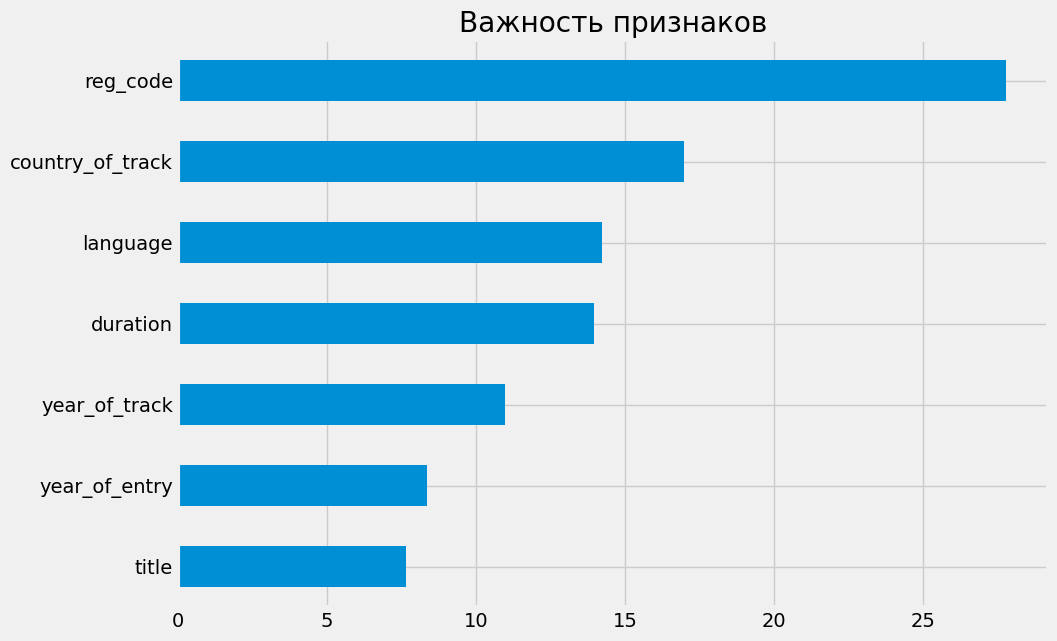

In [51]:
# построим гистограмму значимости признаков для модели CatBoost
# значения отсортированные по возрастанию влияния

plt.figure(figsize = (10,7))
importances = pd.Series(best_model_cb.named_steps['cb'].feature_importances_,index=best_model_cb['cb'].feature_names_).sort_values()

# график
importances.plot.barh(grid=True, title='Важность признаков');

In [52]:
predict_test = best_model_cb.predict(X_test)

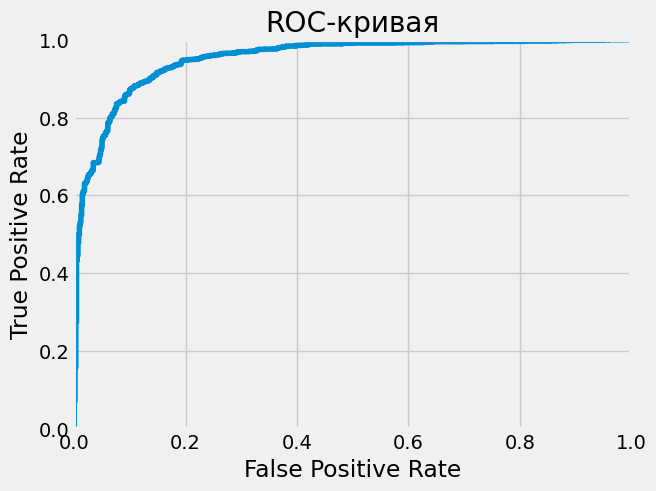

In [53]:
probabilities_test = best_model_cb.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

In [54]:
# рассчитаем дополнительные метрики
print(f'Accuracy: {accuracy_score(y_test, predict_test)}')    
print(f'Полнота: {recall_score(y_test, predict_test)}')     
print(f'Точность: {precision_score(y_test, predict_test)}')  
print(f'F1-мера: {f1_score(y_test,predict_test)}')          
print(f'AUC-ROC:{roc_auc_score(y_test,probabilities_one_test)}')

Accuracy: 0.9007036747458952
Полнота: 0.9403567447045708
Точность: 0.9198473282442748
F1-мера: 0.9299889746416758
AUC-ROC:0.9518103538846767


**Метрики при удаленных столбцах**
df_union = df_union.drop(['original_track_id','track_id','dttm','lyricId','track_remake_type','text','genres'], axis=1)
Accuracy: 0.9010946051602815   
Полнота: 0.9498327759197325   
Точность: 0.9126941617568292   
F1-мера: 0.9308931985796232   
AUC-ROC:0.9553569344002988   
Dummy:0.7010819971320558

**Метрики при удаленных столбцах**
df_union = df_union.drop(['original_track_id','track_id','dttm','lyricId','track_remake_type','text','genres','isrc'], axis=1)
Accuracy: 0.9007036747458952   
Полнота: 0.9403567447045708   
Точность: 0.9198473282442748   
F1-мера: 0.9299889746416758   
AUC-ROC:0.9518103538846767   

In [55]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(X_train,y_train)
print(f'Dummy:{dummy_model.score(X_train,y_train)}')

Dummy:0.7010819971320558
